# EPIC 3

- Als een key user wil ik voor een contact een lijst met toekomstige campagnes genereren volgens de waarschijnlijkheid dat ze zou inschrijven volgens vorige inschrijvingen, afspraken, eigenschappen van de contact zelf en zijn bedrijf, lookalikes etc.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import dotenv
from sqlalchemy import create_engine, text

dotenv.load_dotenv()

True

In [2]:
# Start db
def create_conn():
    driver = os.getenv("DB_DRIVER")
    server = os.getenv("DB_SERVER")
    database = os.getenv("DB_NAME")
    trusted_connection = os.getenv("DB_TRUSTED_CONNECTION")

    return create_engine(
        f"mssql+pyodbc://{server}/{database}?trusted_connection={trusted_connection}&driver={driver}"
    )


engine = create_conn()
# Test connection
connection = engine.connect()
res = connection.execute(text("SELECT @@version;")).fetchone()
connection.close()
res[0]

'Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) \n\tOct  8 2022 05:58:25 \n\tCopyright (C) 2022 Microsoft Corporation\n\tDeveloper Edition (64-bit) on Windows 10 Home 10.0 <X64> (Build 19045: ) (Hypervisor)\n'

## Get the data


In [3]:
SQL_LOCATION = os.getenv("EPIC_3_SQL_LOCATION")
SAVE_LOCATION = os.getenv("EPIC_3_SAVE_LOCATION")
query = open(SQL_LOCATION, "r").read()

df = pd.read_sql(query, engine)
df.drop_duplicates()
df.head()

,crm_campagne_naam,crm_campagne_naam_in_email,crm_campagne_type_campagne,crm_campagne_soort_campagne,crm_sessie_activiteitstype,crm_sessie_product,crm_sessie_thema_naam,crm_inschrijving_aanwezig_afwezig,crm_inschrijving_bron,crm_inschrijving_facturatie_bedrag,...,crm_account_voka_nr,crm_financieledata_aantal_maanden,crm_financieledata_boekjaar,crm_financieledata_fte,crm_financieledata_gewijzigd_op,crm_financieledata_toegevoegde_waarde,crm_info_en_klachten_aanvraag,crm_info_en_klachten_status,crm_activiteitscode_naam,crm_activiteitscode_status
0,OV-P-Groep 288-PP.Develop-Plato 2019,OV-P-Groep 288-PP.Develop-Plato 2019,Project,Offline,GR Plato sessies,OV-Opleidingen-LLT,Algemeen Management,Aanwezig,Email,1200.0,...,77919,12,2019,6.0,2021-07-16 09:58:07,562179.0,435A121C-1C55-E911-80FD-001DD8B72B61,Gesloten,Ijzer en staal,Actief
1,OV-P-Groep 288-PP.Develop-Plato 2019,OV-P-Groep 288-PP.Develop-Plato 2019,Project,Offline,GR Plato sessies,OV-Opleidingen-LLT,Algemeen Management,Aanwezig,Email,1200.0,...,77919,12,2019,6.0,2021-07-16 09:58:07,562179.0,416D86BB-6E3A-E911-80FC-001DD8B72B61,Gesloten,Ijzer en staal,Actief
2,OV-NW-Think Big 30/09/2019,Think Big 2019,Netwerkevenement,Offline,NW Voka Vista,OV-Deelname Netwerkactiviteiten,Groeien,Aanwezig,Website,50.0,...,77919,12,2019,6.0,2021-07-16 09:58:07,562179.0,435A121C-1C55-E911-80FD-001DD8B72B61,Gesloten,Ijzer en staal,Actief
3,OV-NW-Think Big 30/09/2019,Think Big 2019,Netwerkevenement,Offline,NW Voka Vista,OV-Deelname Netwerkactiviteiten,Groeien,Aanwezig,Website,50.0,...,77919,12,2019,6.0,2021-07-16 09:58:07,562179.0,416D86BB-6E3A-E911-80FC-001DD8B72B61,Gesloten,Ijzer en staal,Actief
4,OV-NW-Voka Connect Gent 2020,Voka Nieuwjaarsreceptie Gent 2020,Netwerkevenement,Offline,NW Voka Connect Gent,OV-Netwerkactiviteit-provinciaal,Netwerking,Aanwezig,Website,55.0,...,77919,12,2019,6.0,2021-07-16 09:58:07,562179.0,416D86BB-6E3A-E911-80FC-001DD8B72B61,Gesloten,Ijzer en staal,Actief


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58914 entries, 0 to 58913
Data columns (total 63 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   crm_campagne_naam                                          58914 non-null  object        
 1   crm_campagne_naam_in_email                                 58914 non-null  object        
 2   crm_campagne_type_campagne                                 58914 non-null  object        
 3   crm_campagne_soort_campagne                                58914 non-null  object        
 4   crm_sessie_activiteitstype                                 57884 non-null  object        
 5   crm_sessie_product                                         57890 non-null  object        
 6   crm_sessie_thema_naam                                      57884 non-null  object        
 7   crm_inschrijving_aanwezig_afwez

# Clean the data


## Remove unnessessary columns


In [5]:
df.columns

Index(['crm_campagne_naam', 'crm_campagne_naam_in_email',
       'crm_campagne_type_campagne', 'crm_campagne_soort_campagne',
       'crm_sessie_activiteitstype', 'crm_sessie_product',
       'crm_sessie_thema_naam', 'crm_inschrijving_aanwezig_afwezig',
       'crm_inschrijving_bron', 'crm_inschrijving_facturatie_bedrag',
       'crm_contact_functietitel', 'crm_contact_status',
       'crm_contact_voka_medewerker',
       'crm_persoon_mail_regio_antwerpen_waasland',
       'crm_persoon_mail_regio_brussel_hoofdstedelijk_gewest',
       'crm_persoon_mail_regio_limburg',
       'crm_persoon_mail_regio_mechelen_kempen',
       'crm_persoon_mail_regio_oost_vlaanderen',
       'crm_persoon_mail_regio_vlaams_brabant',
       'crm_persoon_mail_regio_voka_nationaal',
       'crm_persoon_mail_regio_west_vlaanderen',
       'crm_persoon_mail_thema_duurzaamheid',
       'crm_persoon_mail_thema_financieel_fiscaal',
       'crm_persoon_mail_thema_innovatie',
       'crm_persoon_mail_thema_internatio

In [6]:
"""
['crm_campagne_naam', 'crm_campagne_naam_in_email',
       'crm_campagne_type_campagne', 'crm_campagne_soort_campagne', -> Done
       'crm_sessie_activiteitstype', 'crm_sessie_product', -> 
       'crm_sessie_thema_naam', 'crm_inschrijving_aanwezig_afwezig',
       'crm_inschrijving_bron', 'crm_inschrijving_facturatie_bedrag',
       'crm_contact_functietitel', 'crm_contact_status',
       'crm_contact_voka_medewerker',
       'crm_persoon_mail_regio_antwerpen_waasland',
       'crm_persoon_mail_regio_brussel_hoofdstedelijk_gewest',
       'crm_persoon_mail_regio_limburg',
       'crm_persoon_mail_regio_mechelen_kempen',
       'crm_persoon_mail_regio_oost_vlaanderen',
       'crm_persoon_mail_regio_vlaams_brabant',
       'crm_persoon_mail_regio_voka_nationaal',
       'crm_persoon_mail_regio_west_vlaanderen',
       'crm_persoon_mail_thema_duurzaamheid',
       'crm_persoon_mail_thema_financieel_fiscaal',
       'crm_persoon_mail_thema_innovatie',
       'crm_persoon_mail_thema_internationaal_ondernemen',
       'crm_persoon_mail_thema_mobiliteit', 'crm_persoon_mail_thema_omgeving',
       'crm_persoon_mail_thema_sales_marketing_communicatie',
       'crm_persoon_mail_thema_strategie_en_algemeen_management',
       'crm_Persoon_Mail_thema_talent', 'crm_persoon_mail_thema_welzijn',
       'crm_persoon_mail_type_bevraging',
       'crm_persoon_mail_type_communities_en_projecten',
       'crm_persoon_mail_type_netwerkevenementen',
       'crm_persoon_mail_type_nieuwsbrieven',
       'crm_persoon_mail_type_opleidingen',
       'crm_persoon_mail_type_persberichten_belangrijke_meldingen',
       'crm_persoon_marketingcommunicatie', 'crm_persoon_persoonsnr',
       'crm_persoon_reden_van_status', 'crm_account_adres_geografische_regio',
       'crm_account_adres_geografische_subregio', 'crm_account_adres_land',
       'crm_account_adres_plaats', 'crm_account_adres_postcode',
       'crm_account_adres_provincie', 'crm_account_industriezone_naam',
       'crm_account_is_voka_entiteit', 'crm_account_ondernemingsaard',
       'crm_account_ondernemingstype', 'crm_account_primaire_activiteit',
       'crm_account_reden_van_status', 'crm_account_status',
       'crm_account_voka_nr', 'crm_financieledata_aantal_maanden',
       'crm_financieledata_boekjaar', 'crm_financieledata_fte',
       'crm_financieledata_gewijzigd_op',
       'crm_financieledata_toegevoegde_waarde',
       'crm_activiteitscode_naam', 'crm_activiteitscode_status']
"""
y_columns = [
    'crm_campagne_type_campagne',
    'crm_campagne_soort_campagne',
]

y_columns_bis = [
    'crm_sessie_activiteitstype',
    'crm_sessie_product',
    'crm_sessie_thema_naam',
    
]

x_columns = [
    # Contact
    'crm_contact_functietitel',
    'crm_contact_status',
    'crm_contact_voka_medewerker',
    # Persoon
    'crm_persoon_mail_thema_duurzaamheid',
    'crm_persoon_mail_thema_financieel_fiscaal',
    'crm_persoon_mail_thema_innovatie',
    'crm_persoon_mail_thema_internationaal_ondernemen',
    'crm_persoon_mail_thema_mobiliteit', 'crm_persoon_mail_thema_omgeving',
    'crm_persoon_mail_thema_sales_marketing_communicatie',
    'crm_persoon_mail_thema_strategie_en_algemeen_management',
    'crm_Persoon_Mail_thema_talent', 'crm_persoon_mail_thema_welzijn',
    'crm_persoon_mail_type_bevraging',
    'crm_persoon_mail_type_communities_en_projecten',
    'crm_persoon_mail_type_netwerkevenementen',
    'crm_persoon_mail_type_nieuwsbrieven',
    'crm_persoon_mail_type_opleidingen',
    'crm_persoon_mail_type_persberichten_belangrijke_meldingen',
    'crm_persoon_marketingcommunicatie',
    # Account
    'crm_account_adres_geografische_regio',
    'crm_account_adres_geografische_subregio', 'crm_account_adres_land',
    'crm_account_adres_plaats', 'crm_account_adres_postcode',
    'crm_account_adres_provincie', 'crm_account_industriezone_naam',
    'crm_account_is_voka_entiteit', 'crm_account_ondernemingsaard',
    'crm_account_ondernemingstype', 'crm_account_primaire_activiteit','crm_account_status',
    'crm_financieledata_boekjaar', 'crm_financieledata_fte',
           'crm_financieledata_toegevoegde_waarde','crm_activiteitscode_naam', 'crm_activiteitscode_status'

]

In [7]:
y_df = df[y_columns]
y_df

,crm_campagne_type_campagne,crm_campagne_soort_campagne
0,Project,Offline
1,Project,Offline
2,Netwerkevenement,Offline
3,Netwerkevenement,Offline
4,Netwerkevenement,Offline
...,...,...
58909,Opleiding,Offline
58910,Netwerkevenement,Offline
58911,Netwerkevenement,Offline
58912,Netwerkevenement,Offline


In [8]:
y_df_bis = df[y_columns_bis]
y_df_bis

,crm_sessie_activiteitstype,crm_sessie_product,crm_sessie_thema_naam
0,GR Plato sessies,OV-Opleidingen-LLT,Algemeen Management
1,GR Plato sessies,OV-Opleidingen-LLT,Algemeen Management
2,NW Voka Vista,OV-Deelname Netwerkactiviteiten,Groeien
3,NW Voka Vista,OV-Deelname Netwerkactiviteiten,Groeien
4,NW Voka Connect Gent,OV-Netwerkactiviteit-provinciaal,Netwerking
...,...,...,...
58909,EX LL Innovatie en Strategie,OV-Seminarie,Algemeen Management
58910,Voka Box Bar,OV-Netwerkactiviteit-provinciaal,Netwerking
58911,BB Voka Politica,OV-Netwerkactiviteit-Regionaal,Netwerking
58912,BB Voka Politica,OV-Netwerkactiviteit-Regionaal,Netwerking


In [9]:
x_df = df[x_columns]
x_df

,crm_contact_functietitel,crm_contact_status,crm_contact_voka_medewerker,crm_persoon_mail_thema_duurzaamheid,crm_persoon_mail_thema_financieel_fiscaal,crm_persoon_mail_thema_innovatie,crm_persoon_mail_thema_internationaal_ondernemen,crm_persoon_mail_thema_mobiliteit,crm_persoon_mail_thema_omgeving,crm_persoon_mail_thema_sales_marketing_communicatie,...,crm_account_is_voka_entiteit,crm_account_ondernemingsaard,crm_account_ondernemingstype,crm_account_primaire_activiteit,crm_account_status,crm_financieledata_boekjaar,crm_financieledata_fte,crm_financieledata_toegevoegde_waarde,crm_activiteitscode_naam,crm_activiteitscode_status
0,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,2019,6.0,562179.0,Ijzer en staal,Actief
1,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,2019,6.0,562179.0,Ijzer en staal,Actief
2,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,2019,6.0,562179.0,Ijzer en staal,Actief
3,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,2019,6.0,562179.0,Ijzer en staal,Actief
4,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,2019,6.0,562179.0,Ijzer en staal,Actief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58909,Plant manager,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Productie,Bedrijf,"Chemie, petrochemie",Actief,2022,530.0,201864576.0,"Chemie, petrochemie",Actief
58910,Manager,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Hout- en meubelindustrie,Actief,2019,2.0,94083.0,Detailhandel,Actief
58911,Bedrijfsleider,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Consultancy,Actief,2022,0.0,89093.0,Consultancy,Actief
58912,Bedrijfsleider,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,Nee,Diensten,Bedrijf,Consultancy,Actief,2022,0.0,89093.0,Consultancy,Actief


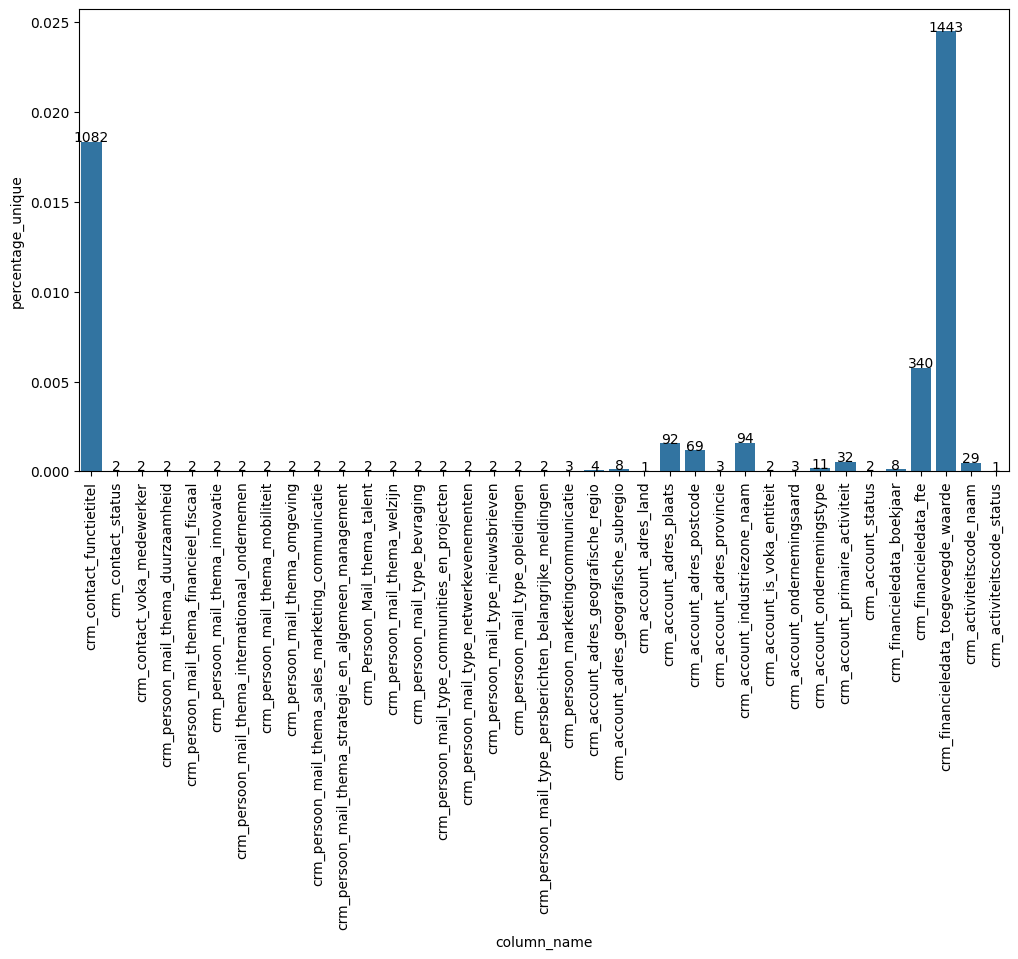

In [10]:
# For the X_data: Count the nuber of unique values per column and pass it to a dataframe
x_df_unique = pd.DataFrame(x_df.nunique()).reset_index()
x_df_unique.columns = ['column_name', 'unique_count']
# Add a column with the percentage of unique values
x_df_unique['percentage_unique'] = x_df_unique['unique_count'] / len(x_df)
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_unique', data=x_df_unique)
# Add the actual count of unique values on top of the bars
for i, row in x_df_unique.iterrows():
    plt.text(row.name, row.percentage_unique, row.unique_count, color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

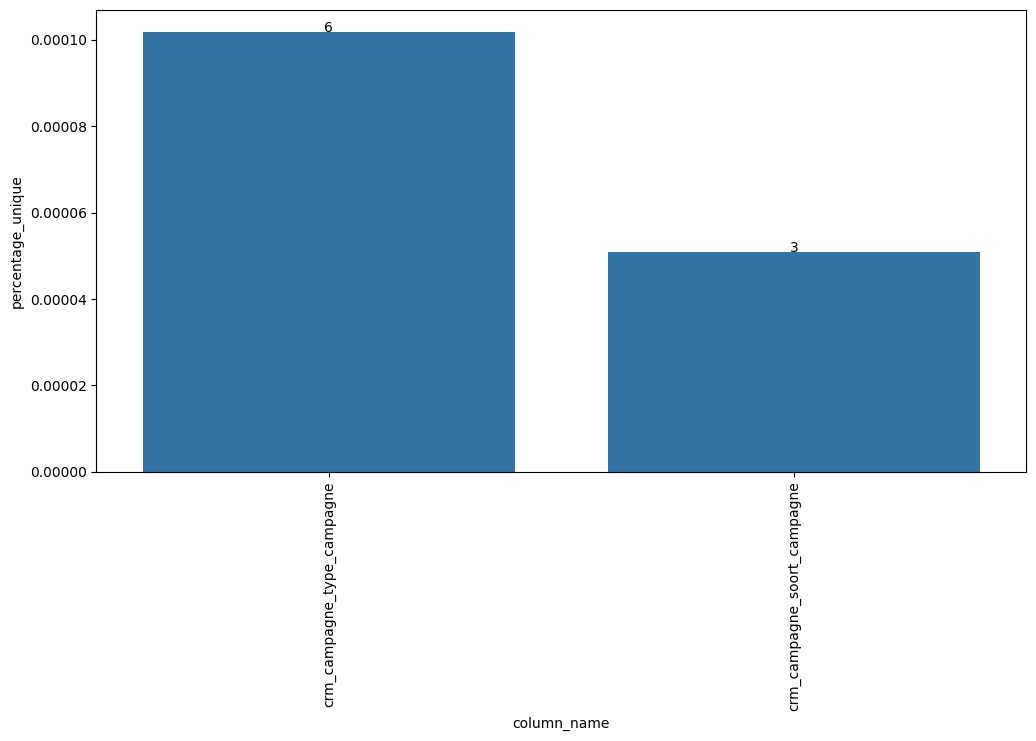

In [11]:
# For the Y_data: Count the nuber of unique values per column and pass it to a dataframe
y_df_unique = pd.DataFrame(y_df.nunique()).reset_index()
y_df_unique.columns = ['column_name', 'unique_count']
# Add a column with the percentage of unique values
y_df_unique['percentage_unique'] = y_df_unique['unique_count'] / len(y_df)
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_unique', data=y_df_unique)
# Add the actual count of unique values on top of the bars
for i, row in y_df_unique.iterrows():
    plt.text(row.name, row.percentage_unique, row.unique_count, color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

In [12]:
x_df.columns

Index(['crm_contact_functietitel', 'crm_contact_status',
       'crm_contact_voka_medewerker', 'crm_persoon_mail_thema_duurzaamheid',
       'crm_persoon_mail_thema_financieel_fiscaal',
       'crm_persoon_mail_thema_innovatie',
       'crm_persoon_mail_thema_internationaal_ondernemen',
       'crm_persoon_mail_thema_mobiliteit', 'crm_persoon_mail_thema_omgeving',
       'crm_persoon_mail_thema_sales_marketing_communicatie',
       'crm_persoon_mail_thema_strategie_en_algemeen_management',
       'crm_Persoon_Mail_thema_talent', 'crm_persoon_mail_thema_welzijn',
       'crm_persoon_mail_type_bevraging',
       'crm_persoon_mail_type_communities_en_projecten',
       'crm_persoon_mail_type_netwerkevenementen',
       'crm_persoon_mail_type_nieuwsbrieven',
       'crm_persoon_mail_type_opleidingen',
       'crm_persoon_mail_type_persberichten_belangrijke_meldingen',
       'crm_persoon_marketingcommunicatie',
       'crm_account_adres_geografische_regio',
       'crm_account_adres_geogra

## Process the data

In [13]:


# Categorize the x columns
categories = {
    "adres": [
        "crm_account_adres_geografische_regio",
        "crm_account_adres_geografische_subregio",
        "crm_account_adres_land",
        "crm_account_adres_plaats",
        "crm_account_adres_postcode",
        "crm_account_adres_provincie",
    ],
    "dates": [
        "crm_financieledata_boekjaar",
    ],
    "industrie_activiteit": [
        "crm_account_industriezone_naam",
        "crm_account_ondernemingsaard",
        "crm_account_ondernemingstype",
        "crm_account_primaire_activiteit",
        "crm_activiteitscode_naam",
        "crm_activiteitscode_status"],
    "voka_relatie": [
        "crm_account_is_voka_entiteit",
        "crm_account_status",
        "crm_contact_voka_medewerker",
         'crm_contact_status',
    ],
    "account_contact": [
        "crm_contact_functietitel"
    ],
    "financieel": [
        "crm_financieledata_toegevoegde_waarde",
        'crm_financieledata_fte', 
    ],
    "mail_thema": [
        'crm_persoon_mail_thema_duurzaamheid',
       'crm_persoon_mail_thema_financieel_fiscaal',
       'crm_persoon_mail_thema_innovatie',
       'crm_persoon_mail_thema_internationaal_ondernemen',
       'crm_persoon_mail_thema_mobiliteit', 
       'crm_persoon_mail_thema_omgeving',
       'crm_persoon_mail_thema_sales_marketing_communicatie',
       'crm_persoon_mail_thema_strategie_en_algemeen_management',
       'crm_Persoon_Mail_thema_talent', 
       'crm_persoon_mail_thema_welzijn',
       'crm_persoon_mail_type_bevraging',
       'crm_persoon_mail_type_communities_en_projecten',
       'crm_persoon_mail_type_netwerkevenementen',
       'crm_persoon_mail_type_nieuwsbrieven',
       'crm_persoon_mail_type_opleidingen',
       'crm_persoon_mail_type_persberichten_belangrijke_meldingen',
       'crm_persoon_marketingcommunicatie',
       ],
}

# Categories to delete: dates
x_df = x_df.drop(columns=categories["dates"])
x_df

,crm_contact_functietitel,crm_contact_status,crm_contact_voka_medewerker,crm_persoon_mail_thema_duurzaamheid,crm_persoon_mail_thema_financieel_fiscaal,crm_persoon_mail_thema_innovatie,crm_persoon_mail_thema_internationaal_ondernemen,crm_persoon_mail_thema_mobiliteit,crm_persoon_mail_thema_omgeving,crm_persoon_mail_thema_sales_marketing_communicatie,...,crm_account_industriezone_naam,crm_account_is_voka_entiteit,crm_account_ondernemingsaard,crm_account_ondernemingstype,crm_account_primaire_activiteit,crm_account_status,crm_financieledata_fte,crm_financieledata_toegevoegde_waarde,crm_activiteitscode_naam,crm_activiteitscode_status
0,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9030) R 4 Industrieweg Wondelgem - Maria...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,6.0,562179.0,Ijzer en staal,Actief
1,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9030) R 4 Industrieweg Wondelgem - Maria...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,6.0,562179.0,Ijzer en staal,Actief
2,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9030) R 4 Industrieweg Wondelgem - Maria...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,6.0,562179.0,Ijzer en staal,Actief
3,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9030) R 4 Industrieweg Wondelgem - Maria...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,6.0,562179.0,Ijzer en staal,Actief
4,Zaakvoerder,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9030) R 4 Industrieweg Wondelgem - Maria...,Nee,Diensten,Bedrijf,Ijzer en staal,Actief,6.0,562179.0,Ijzer en staal,Actief
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58909,Plant manager,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,OV - (9940) Haven Gent 6000 - 6990,Nee,Productie,Bedrijf,"Chemie, petrochemie",Actief,530.0,201864576.0,"Chemie, petrochemie",Actief
58910,Manager,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,None,Nee,Diensten,Bedrijf,Hout- en meubelindustrie,Actief,2.0,94083.0,Detailhandel,Actief
58911,Bedrijfsleider,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,None,Nee,Diensten,Bedrijf,Consultancy,Actief,0.0,89093.0,Consultancy,Actief
58912,Bedrijfsleider,Actief,0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,None,Nee,Diensten,Bedrijf,Consultancy,Actief,0.0,89093.0,Consultancy,Actief


## Bring all columns to  numbers


In [14]:
from sklearn.preprocessing import LabelEncoder

# Based on unique values, decide what to do with the columns
single_cols = [] # 1 unique value

for col in x_df.columns:
    if len(x_df[col].unique()) == 1:
        single_cols.append(col)

In [15]:
# Remove the single columns from the df
x_df = x_df.drop(columns=single_cols)
df_objects = x_df.select_dtypes(include="object")

# Label encode the columns
label_encoder = LabelEncoder()
for col in df_objects.columns:
    x_df[col] = label_encoder.fit_transform(x_df[col])

# Assert that all columns are numeric or float
assert x_df.select_dtypes(include="object").shape[1] == 0
x_df

,crm_contact_functietitel,crm_contact_status,crm_contact_voka_medewerker,crm_persoon_mail_thema_duurzaamheid,crm_persoon_mail_thema_financieel_fiscaal,crm_persoon_mail_thema_innovatie,crm_persoon_mail_thema_internationaal_ondernemen,crm_persoon_mail_thema_mobiliteit,crm_persoon_mail_thema_omgeving,crm_persoon_mail_thema_sales_marketing_communicatie,...,crm_account_adres_provincie,crm_account_industriezone_naam,crm_account_is_voka_entiteit,crm_account_ondernemingsaard,crm_account_ondernemingstype,crm_account_primaire_activiteit,crm_account_status,crm_financieledata_fte,crm_financieledata_toegevoegde_waarde,crm_activiteitscode_naam
0,1008,0,0,1,1,1,1,1,1,1,...,1,11,1,0,0,18,0,6.0,562179.0,16
1,1008,0,0,1,1,1,1,1,1,1,...,1,11,1,0,0,18,0,6.0,562179.0,16
2,1008,0,0,1,1,1,1,1,1,1,...,1,11,1,0,0,18,0,6.0,562179.0,16
3,1008,0,0,1,1,1,1,1,1,1,...,1,11,1,0,0,18,0,6.0,562179.0,16
4,1008,0,0,1,1,1,1,1,1,1,...,1,11,1,0,0,18,0,6.0,562179.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58909,725,0,0,1,1,1,1,1,1,1,...,1,89,1,1,0,4,0,530.0,201864576.0,4
58910,578,0,0,1,1,1,1,1,1,1,...,1,94,1,0,0,16,0,2.0,94083.0,6
58911,79,0,0,1,1,1,1,1,1,1,...,1,94,1,0,0,5,0,0.0,89093.0,5
58912,79,0,0,1,1,1,1,1,1,1,...,1,94,1,0,0,5,0,0.0,89093.0,5


In [16]:
# Save the label encoder
import pickle

with open(os.path.join(SAVE_LOCATION, "label_encoder_x.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

## Processing the y data

In [17]:
# Create a new encoder for the y_df
label_encoder_y = LabelEncoder()
y_df = y_df.apply(label_encoder_y.fit_transform)
y_df

# Assert that all columns are numeric or float
assert y_df.select_dtypes(include="object").shape[1] == 0
y_df

,crm_campagne_type_campagne,crm_campagne_soort_campagne
0,4,0
1,4,0
2,2,0
3,2,0
4,2,0
...,...,...
58909,3,0
58910,2,0
58911,2,0
58912,2,0


In [18]:
# Save the label encoder

with open(os.path.join(SAVE_LOCATION, "label_encoder_y.pkl"), "wb") as f:
    pickle.dump(label_encoder_y, f)

In [19]:
# Creating a test and train set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x_df, y_df, test_size=0.1, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53022, 34), (5892, 34), (53022, 2), (5892, 2))

## What type of ml do I need?
- Multiclass Classification
- Models to use
  - Logistic regression
  - Random Forest classifier
  - KNN
  - SVC

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import MissingIndicator
# random oversampling
from imblearn.over_sampling import RandomOverSampler

# Missing values 

imputer = MissingIndicator(features="all")

# Write a pipeline for each model
# Random Forest
rf_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("rf", RandomForestClassifier()),
    ]
)

# Logistic Regression
log_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", StandardScaler()),
        ("log", LogisticRegression()),
    ]
)

# Gradient Boosting
gb_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", StandardScaler()),
        ("gb", GradientBoostingClassifier()),
    ]
)

# KNN
knn_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier()),
    ]
)


# Create a dictionary with all the pipelines
pipelines = {
    "rf": rf_pipeline,
    "log": log_pipeline,
    "gb": gb_pipeline,
    "knn": knn_pipeline,
}

In [21]:
# Count the values of the y_train
for col in y_train.columns:
    print(y_train[col].value_counts())

crm_campagne_type_campagne
3    18633
2    16851
4    13990
1     2951
0      363
5      234
Name: count, dtype: int64
crm_campagne_soort_campagne
0    43123
2     6280
1     3619
Name: count, dtype: int64


In [22]:
# Use over sampling to balance the data
ros = RandomOverSampler(random_state=42) # TODO: Test een randomUnderSampler

# Join the X and y train data
training_data = {
}


for column in y_train.columns:
    print(y_train[column].value_counts())
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train[column])
    training_data[column] = (X_train_ros, y_train_ros)

# Check the new shapes
for key, value in training_data.items():
    print(key, value[0].shape, value[1].shape)
    print(value[1].value_counts())

crm_campagne_type_campagne
3    18633
2    16851
4    13990
1     2951
0      363
5      234
Name: count, dtype: int64
crm_campagne_soort_campagne
0    43123
2     6280
1     3619
Name: count, dtype: int64
crm_campagne_type_campagne (111798, 34) (111798,)
crm_campagne_type_campagne
3    18633
2    18633
4    18633
1    18633
0    18633
5    18633
Name: count, dtype: int64
crm_campagne_soort_campagne (129369, 34) (129369,)
crm_campagne_soort_campagne
0    43123
2    43123
1    43123
Name: count, dtype: int64


In [23]:
# Test on each pipeline 

scores = {
    "rf": [],
    "log": [],
    "gb": [],
    "knn": [],
}
for pipe_name, pipeline in pipelines.items():
    print(f"Training model: {pipe_name}")
    for y_col in y_df.columns:
        pipeline.fit(training_data[y_col][0], training_data[y_col][1])
        y_pred = pipeline.predict(X_test)
        score = accuracy_score(y_test[y_col], y_pred)
        cm = confusion_matrix(y_test[y_col], y_pred)

        print(f"       Score: {score}")
        print(f"       Confusion matrix: \n {cm}")
        print(f"       Classification report: \n {classification_report(y_test[y_col], y_pred)}")

        scores[pipe_name].append({
            "column": y_col,
            "score": score,
            "confusion_matrix": cm
        })

Training model: rf
       Score: 0.32501697216564834
       Confusion matrix: 
 [[   0    0   40    0    0    0]
 [   0    0  355    0    0    0]
 [   0    0 1915    0    0    0]
 [   0    0 1988    0    0    0]
 [   0    0 1571    0    0    0]
 [   0    0   23    0    0    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00       355
           2       0.33      1.00      0.49      1915
           3       0.00      0.00      0.00      1988
           4       0.00      0.00      0.00      1571
           5       0.00      0.00      0.00        23

    accuracy                           0.33      5892
   macro avg       0.05      0.17      0.08      5892
weighted avg       0.11      0.33      0.16      5892



c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.8099117447386287
       Confusion matrix: 
 [[4772    0    0]
 [ 404    0    0]
 [ 716    0    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      4772
           1       0.00      0.00      0.00       404
           2       0.00      0.00      0.00       716

    accuracy                           0.81      5892
   macro avg       0.27      0.33      0.30      5892
weighted avg       0.66      0.81      0.72      5892

Training model: log


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.003903598099117447
       Confusion matrix: 
 [[   0    0    0    0    0   40]
 [   0    0    0    0    0  355]
 [   0    0    0    0    0 1915]
 [   0    0    0    0    0 1988]
 [   0    0    0    0    0 1571]
 [   0    0    0    0    0   23]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00       355
           2       0.00      0.00      0.00      1915
           3       0.00      0.00      0.00      1988
           4       0.00      0.00      0.00      1571
           5       0.00      1.00      0.01        23

    accuracy                           0.00      5892
   macro avg       0.00      0.17      0.00      5892
weighted avg       0.00      0.00      0.00      5892



c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.06856754921928038
       Confusion matrix: 
 [[   0 4772    0]
 [   0  404    0]
 [   0  716    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4772
           1       0.07      1.00      0.13       404
           2       0.00      0.00      0.00       716

    accuracy                           0.07      5892
   macro avg       0.02      0.33      0.04      5892
weighted avg       0.00      0.07      0.01      5892

Training model: gb


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.33740665308893414
       Confusion matrix: 
 [[   0    0    0   40    0    0]
 [   0    0    0  355    0    0]
 [   0    0    0 1915    0    0]
 [   0    0    0 1988    0    0]
 [   0    0    0 1571    0    0]
 [   0    0    0   23    0    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00       355
           2       0.00      0.00      0.00      1915
           3       0.34      1.00      0.50      1988
           4       0.00      0.00      0.00      1571
           5       0.00      0.00      0.00        23

    accuracy                           0.34      5892
   macro avg       0.06      0.17      0.08      5892
weighted avg       0.11      0.34      0.17      5892



c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.06856754921928038
       Confusion matrix: 
 [[   0 4772    0]
 [   0  404    0]
 [   0  716    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4772
           1       0.07      1.00      0.13       404
           2       0.00      0.00      0.00       716

    accuracy                           0.07      5892
   macro avg       0.02      0.33      0.04      5892
weighted avg       0.00      0.07      0.01      5892

Training model: knn


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.33740665308893414
       Confusion matrix: 
 [[   0    0    0   40    0    0]
 [   0    0    0  355    0    0]
 [   0    0    0 1915    0    0]
 [   0    0    0 1988    0    0]
 [   0    0    0 1571    0    0]
 [   0    0    0   23    0    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00       355
           2       0.00      0.00      0.00      1915
           3       0.34      1.00      0.50      1988
           4       0.00      0.00      0.00      1571
           5       0.00      0.00      0.00        23

    accuracy                           0.34      5892
   macro avg       0.06      0.17      0.08      5892
weighted avg       0.11      0.34      0.17      5892



c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

       Score: 0.8099117447386287
       Confusion matrix: 
 [[4772    0    0]
 [ 404    0    0]
 [ 716    0    0]]
       Classification report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      4772
           1       0.00      0.00      0.00       404
           2       0.00      0.00      0.00       716

    accuracy                           0.81      5892
   macro avg       0.27      0.33      0.30      5892
weighted avg       0.66      0.81      0.72      5892



c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

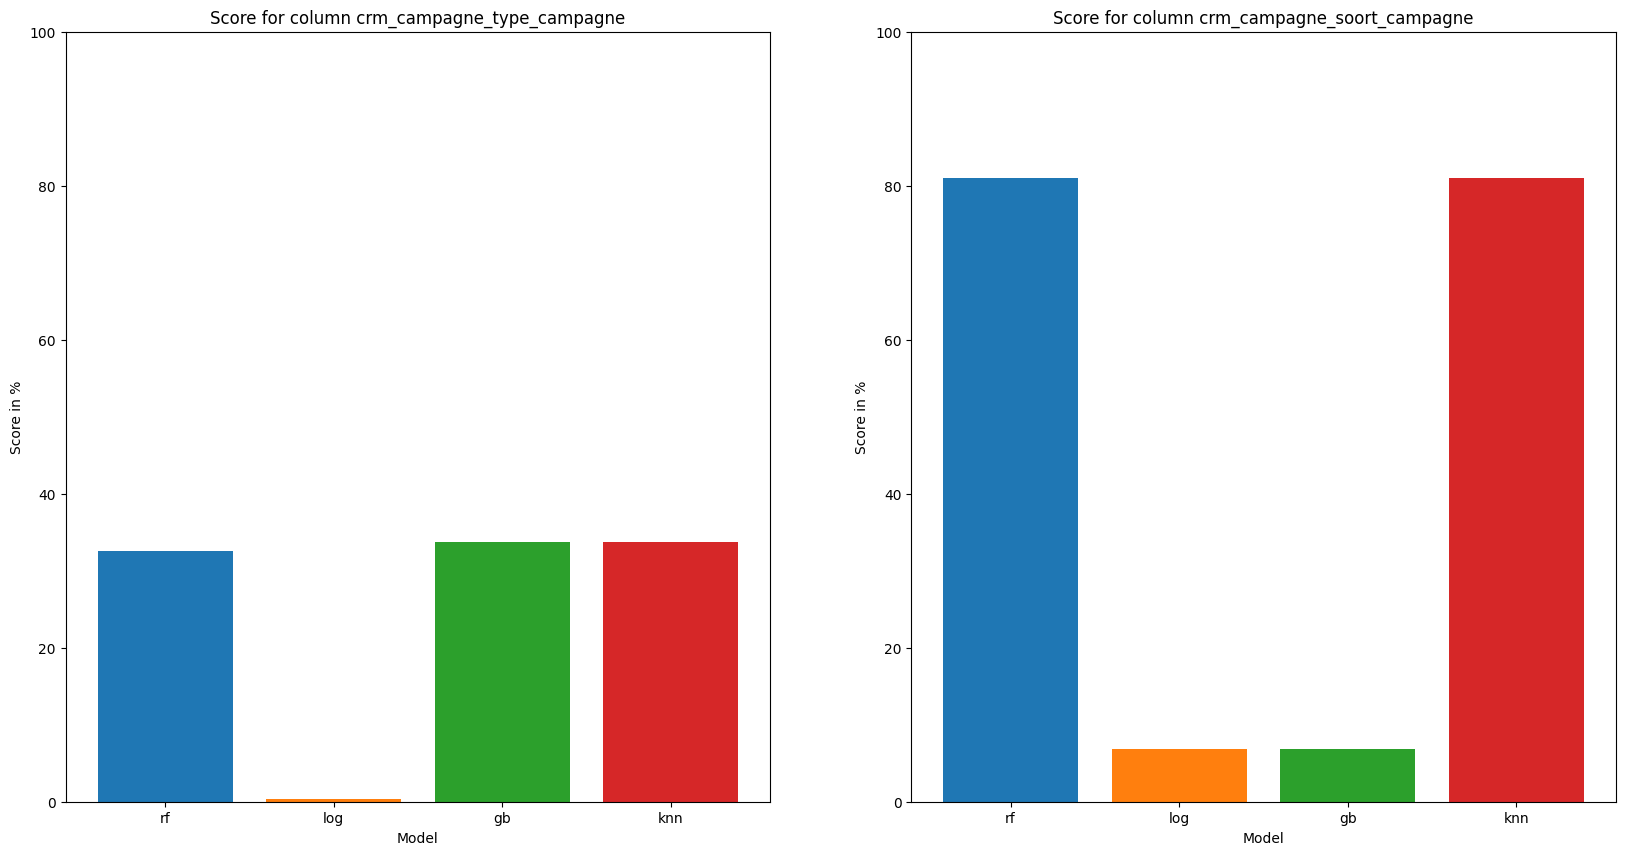

In [24]:
# Plot the scores in X barplots, 1 for each y-column

ax, fig = plt.subplots(1, len(y_test.columns), figsize=(20, 10))
# Enable horizontal grid
for pipe_name, score_list in scores.items():
    for i, score in enumerate(score_list):
        fig[i].bar(pipe_name, score["score"] * 100)
        # Write the score on top of the bar
        fig[i].set_title(f'Score for column {score["column"]}')
        
        fig[i].set_xlabel("Model")
        fig[i].set_ylabel("Score in %")
        fig[i].set_ylim([0, 100])
        fig[i].grid(axis="y")
        
plt.show()

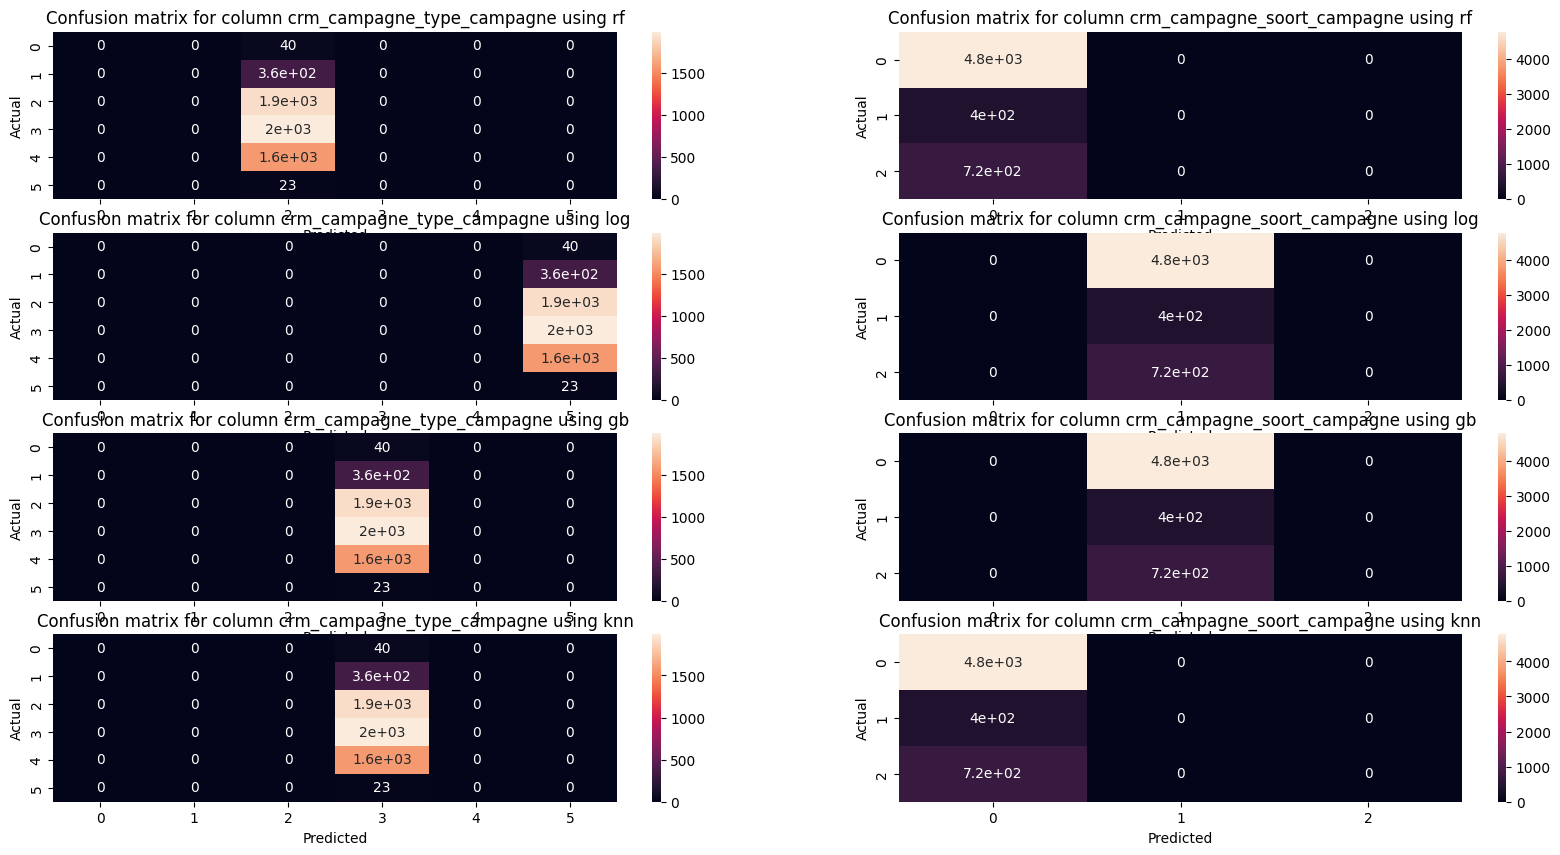

'\n1. Hoe komt het dat de scores zo vreemd zijn?\n    - De data is niet goed verdeeld\n    - Modellen verkeerd behandeld / gekozen\n    - Data niet goed behandeld\n2. Is de SQL query goed?\n3. (Optioneel) Probeer met nieuwe modellen\n-> Schrijf in een apart bestand\n'

In [25]:
# Visualize the confusion matrixes

fig, ax = plt.subplots(len(pipelines.keys()), len(y_test.columns), figsize=(20, 10))
for pipe_name, score_list in scores.items():
    for i, score in enumerate(score_list):
        sns.heatmap(score["confusion_matrix"], annot=True, ax=ax[list(pipelines.keys()).index(pipe_name), i])
        ax[list(pipelines.keys()).index(pipe_name), i].set_title(f'Confusion matrix for column {score["column"]} using {pipe_name}')
        ax[list(pipelines.keys()).index(pipe_name), i].set_xlabel("Predicted")
        ax[list(pipelines.keys()).index(pipe_name), i].set_ylabel("Actual")
plt.show()


# PELLE EN NICO: TODO
"""
1. Hoe komt het dat de scores zo vreemd zijn?
    - De data is niet goed verdeeld
    - Modellen verkeerd behandeld / gekozen
    - Data niet goed behandeld
2. Is de SQL query goed?
3. (Optioneel) Probeer met nieuwe modellen
-> Schrijf in een apart bestand
"""